# Import Libs

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

import os
import numpy as np
from glob import glob
import glob
import random
import imageio
from torchvision import transforms
from collections import defaultdict

import segmentation_models_pytorch as smp

# Import Dataset
- Import folder with images
- Import folder with masks
- Create list with training and testing data

In [2]:
# get all the image and mask path and number of images
folder_data_train = glob.glob("split/train/amostras/*tiff")
folder_mask_train = glob.glob("split/train/labels/*png")

folder_data_val = glob.glob("split/val/amostras/*tiff")
folder_mask_val = glob.glob("split/val/labels/*png")

folder_data_test = glob.glob("split/test/amostras/*tiff")
folder_mask_test = glob.glob("split/test/labels/*png")

train_image_paths = folder_data_train[:]
val_image_paths = folder_data_val[:]
test_image_paths = folder_data_test[:]

train_mask_paths = folder_mask_train[:]
val_mask_paths = folder_mask_val[:]
test_mask_paths = folder_mask_test[:]

In [3]:
color2index = {
    (0, 0, 0) : 0,
    (1, 0, 0) : 1
}

def rgb2mask(img):

    assert len(img.shape) == 3
    height, width, ch = img.shape
    assert ch == 3

    W = np.power(256, [[0],[1],[2]])

    img_id = img.dot(W).squeeze(-1) 
    values = np.unique(img_id)

    mask = np.zeros(img_id.shape)

    for i, c in enumerate(values):
        try:
            mask[img_id==c] = color2index[tuple(img[img_id==c][0])] 
        except:
            pass
    return mask

# Test

In [4]:
class CustomDataset(data.Dataset):
    def __init__(self, image_paths, target_paths, transform=None, transform_label=None):

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transform = transform
        self.transform_label = transform_label
        
    def __getitem__(self, index):

        image = imageio.imread(self.image_paths[index])
        image = np.asarray(image, dtype='float32')
        #image = image[:,:,0:3] To apply only the RGB channels
        #print(image.shape)
        
        m = imageio.imread(self.target_paths[index])
        m = np.asarray(m, dtype='int64')
        mask = rgb2mask(m)
        
        #mask = np.argmax(mask, axis=2)
        #mask = mask.reshape(160,160)
        #mask = np.where(mask==2, 0, mask)
        #print(mask.shape)
        
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        
        if self.transform is not None:
            image = self.transform(image)
            
        random.seed(seed)
        torch.manual_seed(seed)
        if self.transform_label is not None:
            mask = self.transform(mask)
            mask = mask.squeeze(0)
        
        #print(mask.shape)
        return image, mask

    def __len__(self):  # return count of sample we have

        return len(self.image_paths)
    
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip()])


train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=transform, transform_label=transform)
val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=transforms.ToTensor(), transform_label=None)
test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=transforms.ToTensor(), transform_label=None)

In [5]:
image_datasets = {
    'train': train_dataset, 'val': val_dataset, 'test': test_dataset
}

#dataloaders = {
#    'train': torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0),
#    'val': torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0),
#    'test': torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)
#}

# Import Model

In [6]:
ENCODER = 'efficientnet-b7' #'resnet101' #'efficientnet-b7' #'vgg16'
ENCODER_WEIGHTS = 'imagenet' #'imagenet'
CLASSES = ['eucalyptus']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    in_channels = 3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [7]:
#loss = smp.utils.losses.CrossEntropyLoss()
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5) #, ignore_channels=[False, True, False, False]),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.01),
])

In [8]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

In [ ]:
max_score = 0
for i in range(0, 85):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, 'datasets/eucaliptos/3b_vgg16.pth')
        print('Model saved!')
        
    if i == 15:
        optimizer.param_groups[0]['lr'] = 0.001
        print('Decrease decoder learning rate to 0.001!')        
    if i == 30:
        optimizer.param_groups[0]['lr'] = 0.0001
        print('Decrease decoder learning rate to 0.0001!')      
    if i==70:
        optimizer.param_groups[0]['lr'] = 0.00001
        print('Decrease decoder learning rate to 0.00001!')

In [10]:
model = torch.load('models/model_eucaliptos_effb7.pth')
#model = torch.load('datasets/eucaliptos/3b_r101.pth')
#model = torch.load('datasets/eucaliptos/3b_x101.pth')
#model = torch.load('datasets/eucaliptos/3b_vgg16.pth')

#model = model.to(DEVICE)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

# EVAL MODEL

In [11]:
import math
with torch.no_grad():
    model.eval()   # Set model to the evaluation mode
    test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=61, shuffle=False, num_workers=0)

    # Get the first batch
    inp, lab = next(iter(test_loader)) #test_loader

    inp = inp.to(DEVICE)
    lab = lab.to(DEVICE)

    # Predict
    pred = model(inp)
    #pred = pred.data.cpu().numpy()
    print(inp.shape)

torch.Size([61, 10, 160, 160])


In [12]:
lbl = lab.cpu().numpy().reshape(-1)
target = pred.data.cpu().numpy().reshape(-1)

In [13]:
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, jaccard_score, accuracy_score, precision_score, recall_score
def compute_metrics(label, target):
    
    
    acc_25 = accuracy_score(label, np.where(target>0.25, 1, 0))
    acc_50 = accuracy_score(label, np.where(target>0.5, 1, 0))
    acc_75 = accuracy_score(label, np.where(target>0.75, 1, 0))
    
    p_25 = precision_score(label, np.where(target>0.25, 1, 0))
    p_50 = precision_score(label, np.where(target>0.5, 1, 0))
    p_75 = precision_score(label, np.where(target>0.75, 1, 0))
    
    r_25 = recall_score(label, np.where(target>0.25, 1, 0))
    r_50 = recall_score(label, np.where(target>0.5, 1, 0))
    r_75 = recall_score(label, np.where(target>0.75, 1, 0))
    
    iou_25 = jaccard_score(label, np.where(target>0.25, 1, 0))
    iou_50 = jaccard_score(label, np.where(target>0.5, 1, 0))
    iou_75 = jaccard_score(label, np.where(target>0.75, 1, 0))
    
    f_25 = f1_score(label, np.where(target>0.25,1,0))
    f_50 = f1_score(label, np.where(target>0.5,1,0))
    f_75 = f1_score(label, np.where(target>0.75,1,0))
    
    print('Accuracy', round(acc_25*100, 2), '| ', round(acc_50*100, 2), '| ', round(acc_75*100, 2))
    print('Precision', round(p_25*100, 2), '| ', round(p_50*100, 2), '| ', round(p_75*100, 2))
    print('Recall', round(r_25*100, 2), '| ', round(r_50*100, 2), '| ', round(r_75*100, 2))
    print('F-score', round(f_25*100, 2), '| ', round(f_50*100, 2), '| ', round(f_75*100, 2))
    print('IoU', round(iou_25*100, 2), '| ', round(iou_50*100, 2), '| ', round(iou_75*100, 2))
    
compute_metrics(lbl, target)

Accuracy 92.11 |  92.18 |  92.24
Precision 82.59 |  82.92 |  83.25
Recall 93.58 |  93.29 |  92.97
F-score 87.74 |  87.8 |  87.85
IoU 78.16 |  78.25 |  78.33


--------------------


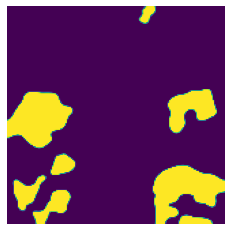

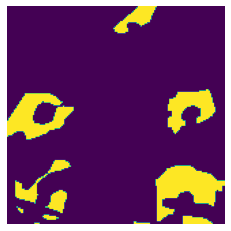

--------------------


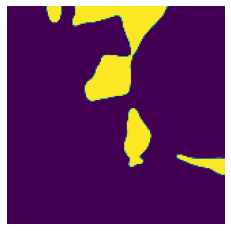

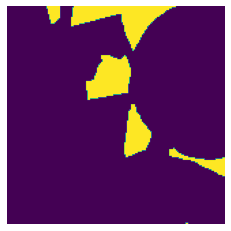

--------------------


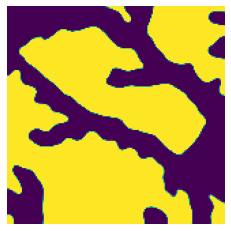

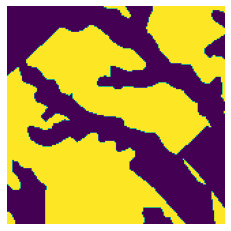

--------------------


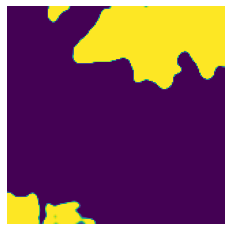

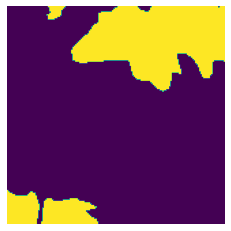

--------------------


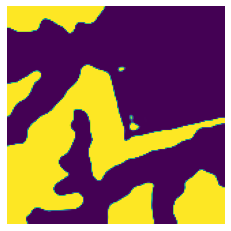

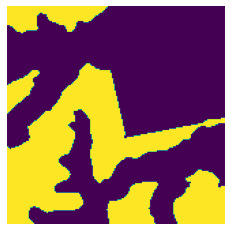

--------------------


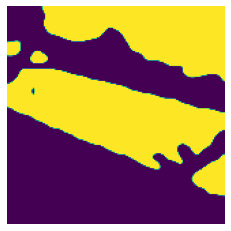

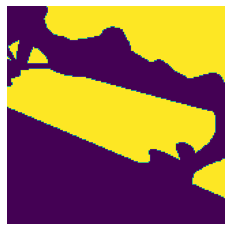

--------------------


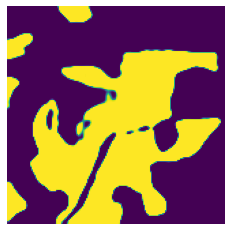

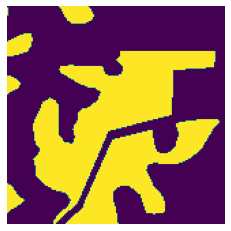

--------------------


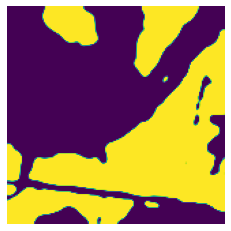

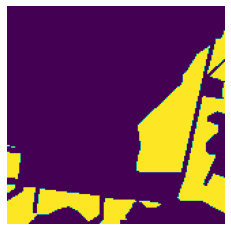

--------------------


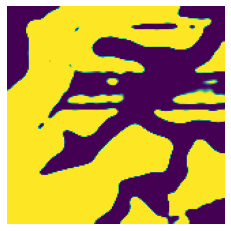

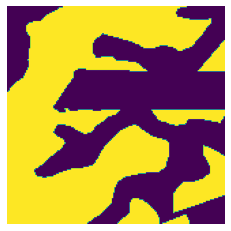

--------------------


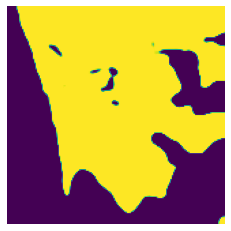

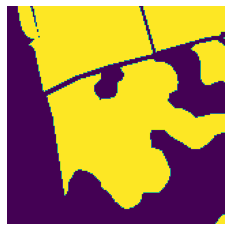

--------------------


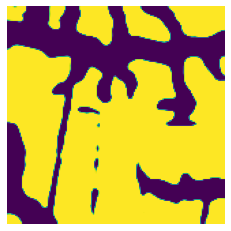

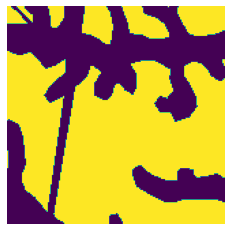

--------------------


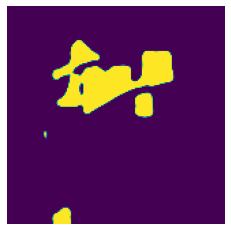

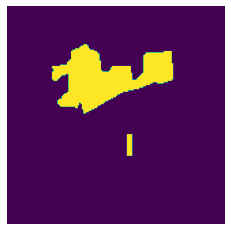

--------------------


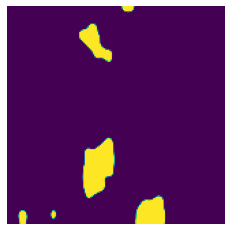

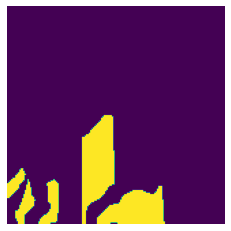

--------------------


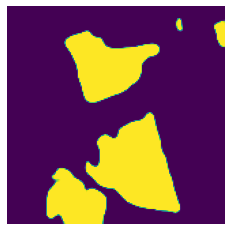

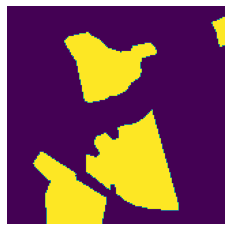

--------------------


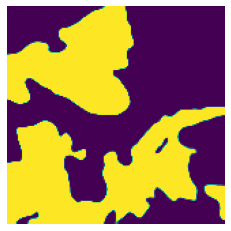

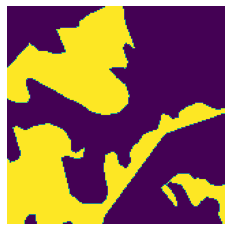

--------------------


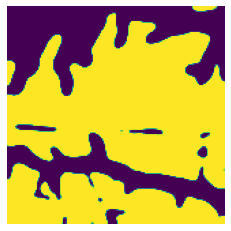

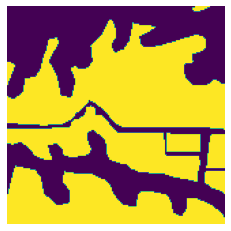

--------------------


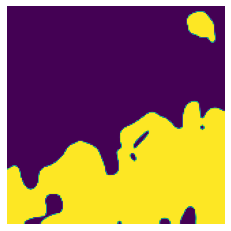

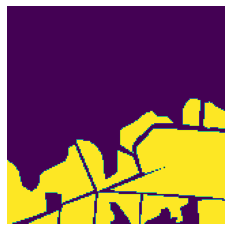

--------------------


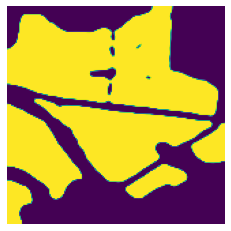

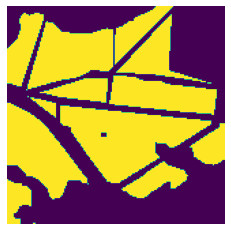

--------------------


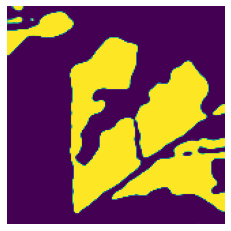

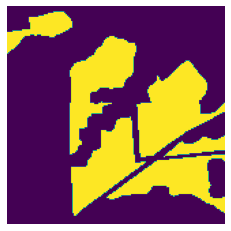

--------------------


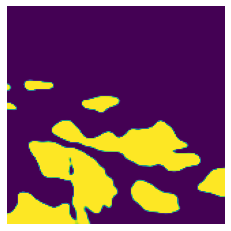

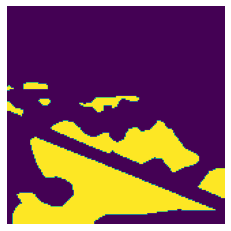

--------------------


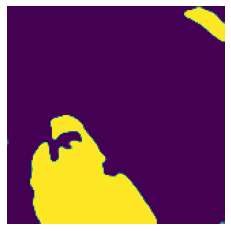

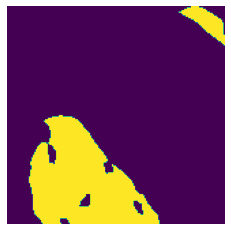

--------------------


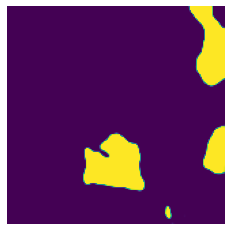

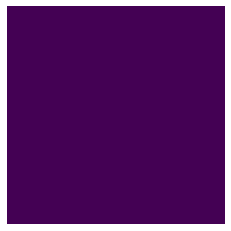

--------------------


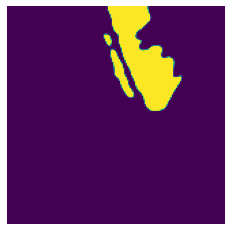

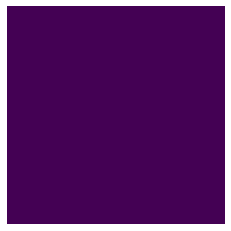

--------------------


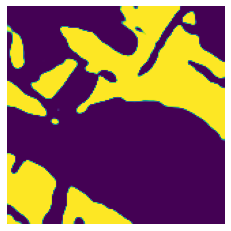

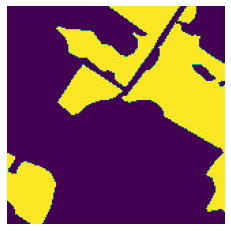

--------------------


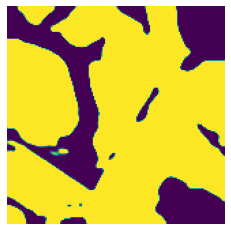

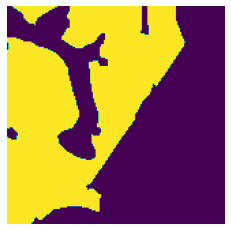

--------------------


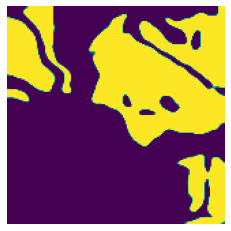

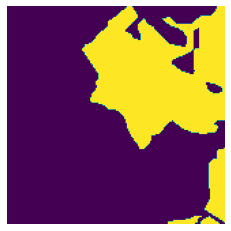

--------------------


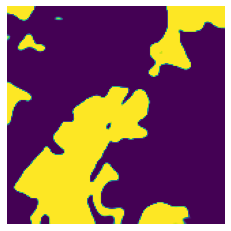

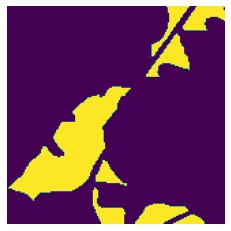

--------------------


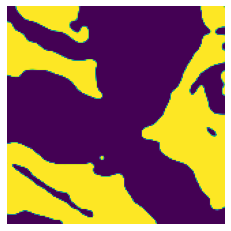

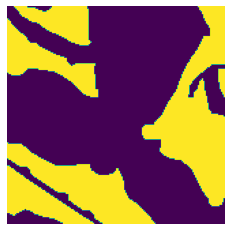

--------------------


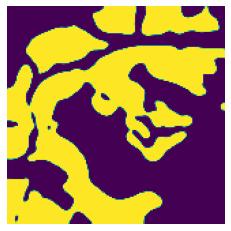

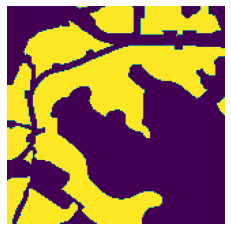

--------------------


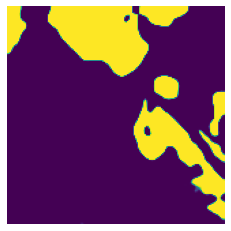

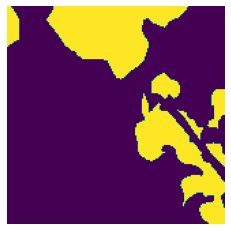

--------------------


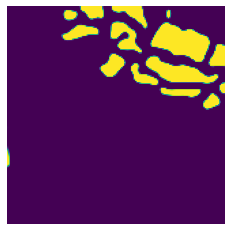

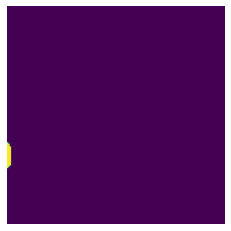

--------------------


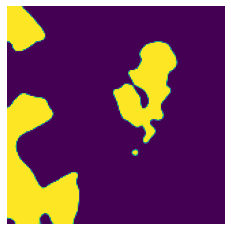

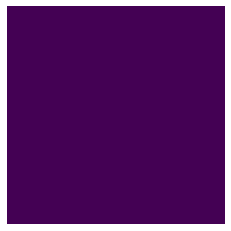

--------------------


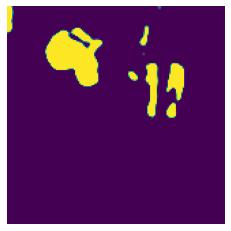

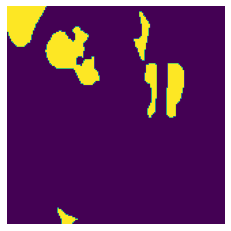

--------------------


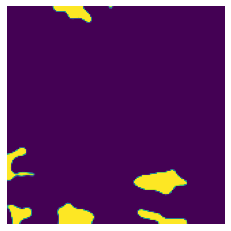

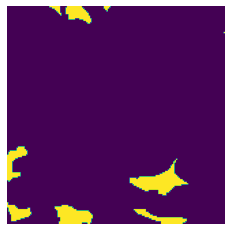

--------------------


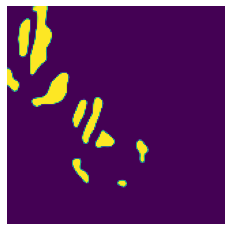

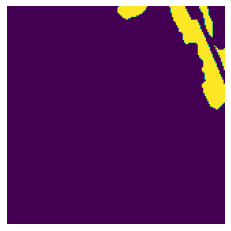

--------------------


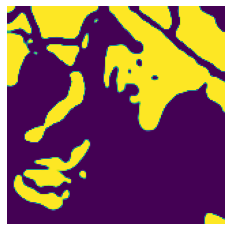

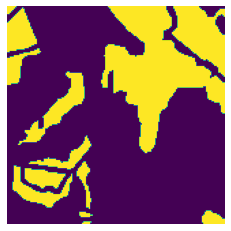

--------------------


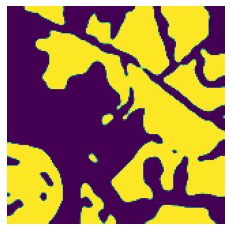

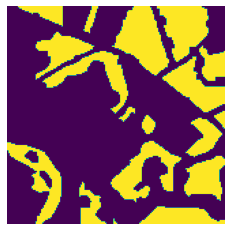

--------------------


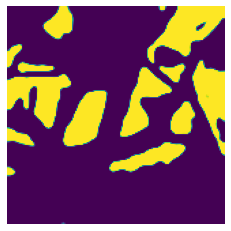

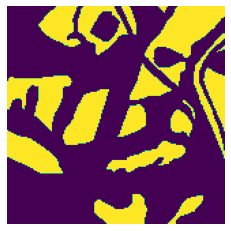

--------------------


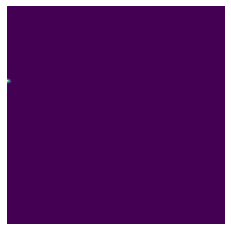

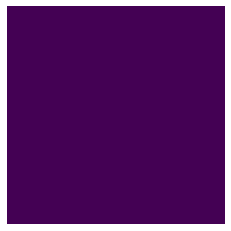

--------------------


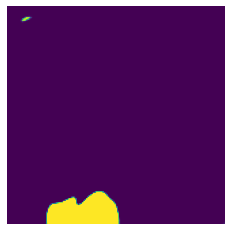

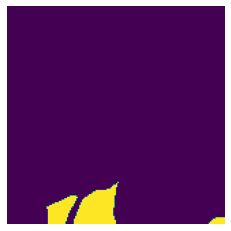

--------------------


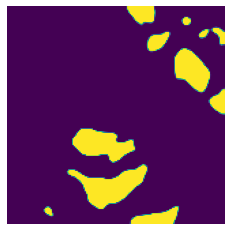

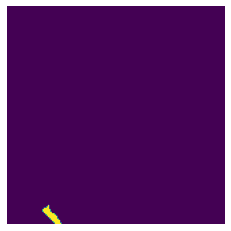

--------------------


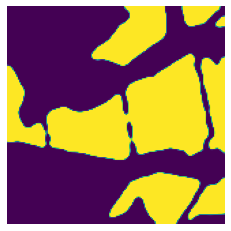

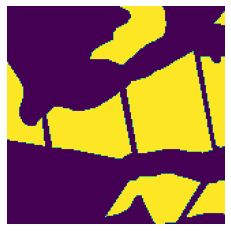

--------------------


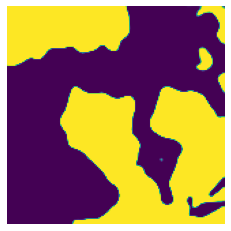

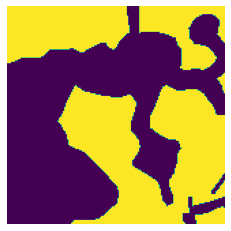

--------------------


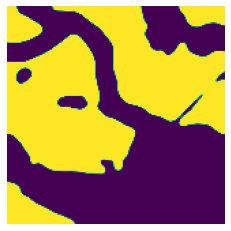

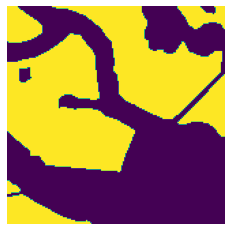

--------------------


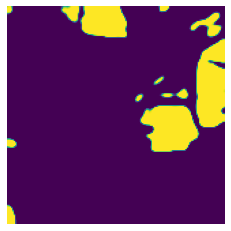

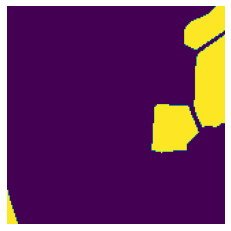

--------------------


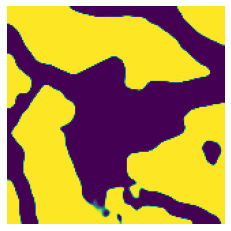

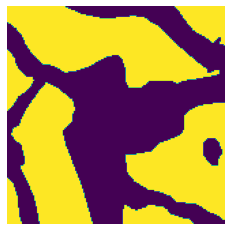

--------------------


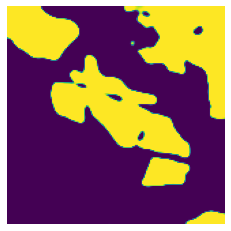

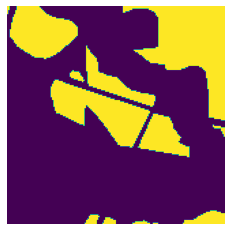

--------------------


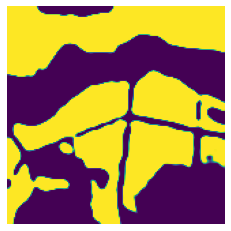

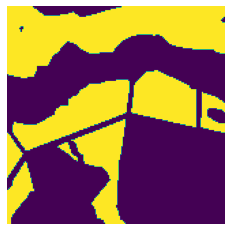

--------------------


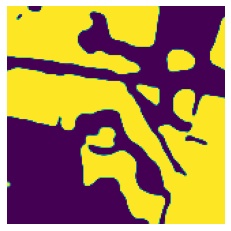

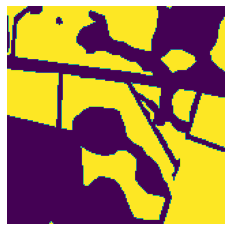

--------------------


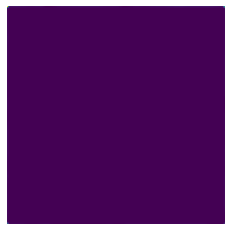

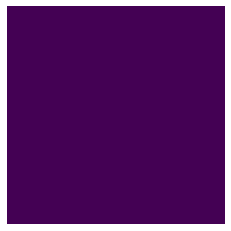

--------------------


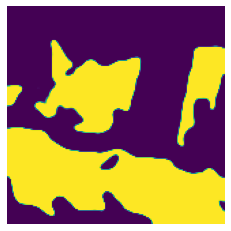

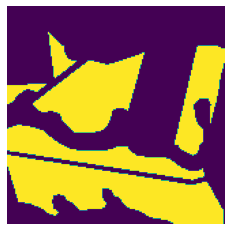

--------------------


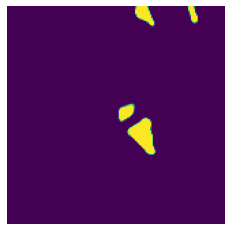

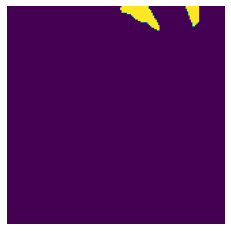

--------------------


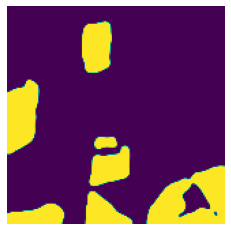

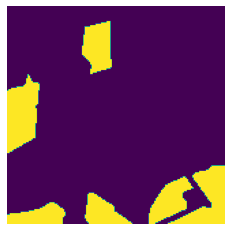

--------------------


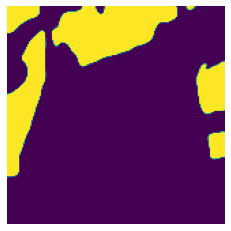

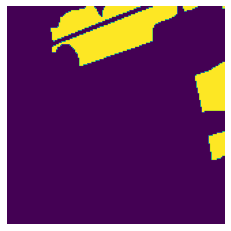

--------------------


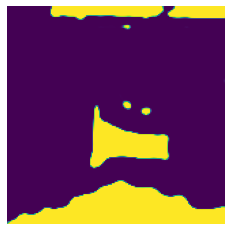

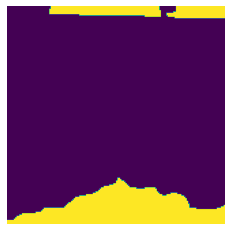

--------------------


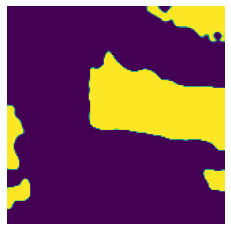

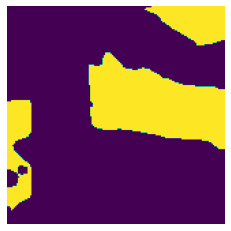

--------------------


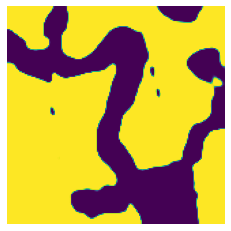

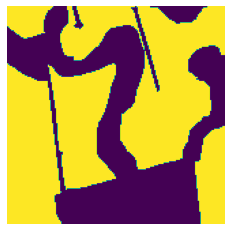

--------------------


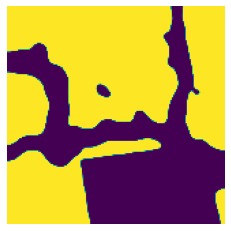

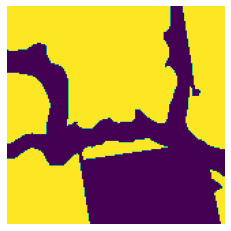

--------------------


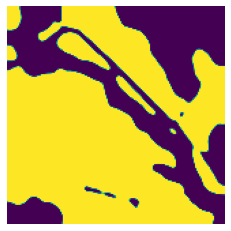

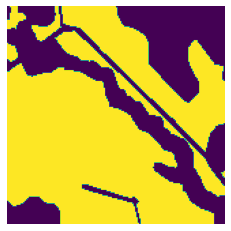

--------------------


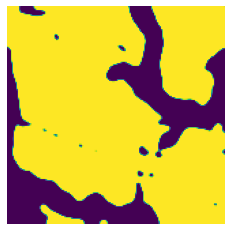

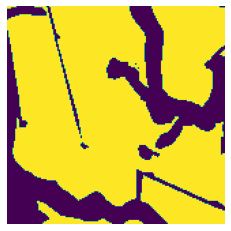

--------------------


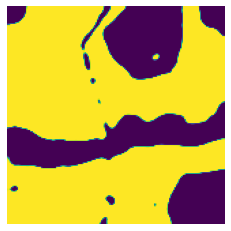

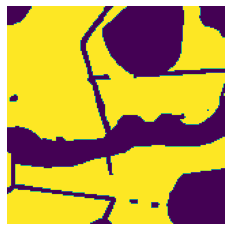

In [14]:
import matplotlib.pyplot as plt
for i in range(61):
    #if i == 2 or i==8 or i==9 or i==10:
    print('-'*20)

    pred_full = pred[i].data.cpu().numpy().reshape(160,160)

    plt.imshow(pred_full)
    plt.axis('off')
    #plt.savefig('224_imgs/pred'+str(i)+'.png', dpi=500, bbox_inches='tight', pad_inches=0)
    plt.show()

    plt.imshow(lab[i].cpu())
    plt.axis('off')
    #plt.savefig('224_imgs/lab'+str(i)+'.png', dpi=500, bbox_inches='tight', pad_inches=0)
    plt.show()

# CODE TO GENERATE MOSAICKING

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
img_path = 'F:/0Eucaliptos/temp/fig_paper.tif'
lbl_path = 'F:/0Eucaliptos/temp/mask_paper.tif'

def mosaicking(img_path, stride, window, model):
    image = imageio.imread(img_path).astype('float32') # Ler imagem
    image = image.reshape(1, 10, 1120, 2080) # formato (1, C, H, W)

    print(image.shape)
    image = torch.from_numpy(image) # passar para tensor para ler a imagem
    #print(image.shape) # (1, C, H, W)
    
    width = image.shape[2]
    height = image.shape[3]

    new_height = int((height-window)/stride)*stride 
    new_width = int((width-window)/stride)*stride

    img_width = new_width+window
    img_height = new_height+window

    img_final = np.zeros((1120, 2080), dtype="float32")
    contador_final = np.zeros((1120, 2080), dtype='float32')
    
    model.eval()
    
    for row in range(0,new_width+1, stride):
        print('row', row)
        for col in range(0,new_height+1, stride):

            actual_img = image[:, :, row:row+window, col:col+window].to(DEVICE).float()
            actual_pred = model(actual_img)
            actual_pred = actual_pred.data.cpu().numpy()
            actual_pred = actual_pred.reshape(window,window)

            for pjlin in range(0, window):
                p1 = row + pjlin
                for pjcol in range(0, window):
                    p2 = col + pjcol   
                    value = actual_pred[pjlin, pjcol]
                    img_final[p1,p2] += value
                    contador_final[p1,p2] += 1
    
    classified_image = img_final/contador_final
    classified_image = np.nan_to_num(classified_image)
    return classified_image

def mosaick_metrics(clf_img, lbl_path):
    clf_img = np.nan_to_num(clf_img)
    clf_img = clf_img.reshape(-1)
    
    lbl = imageio.imread(lbl_path).astype('int16')
    lbl = np.where(lbl>1, 0, lbl)
    lbl = lbl.reshape(-1)

    roc = roc_auc_score(lbl, clf_img)
    pr = average_precision_score(lbl, clf_img)
    print('ROC:', round(roc*100,2), ' | PR:', round(pr*100, 2))

# GET MOSAICKING CLASSIFICATIONS

In [ ]:
# Get classifications
clf_5 = mosaicking(img_path, 5, 160, model)
clf_10 = mosaicking(img_path, 10, 160, model)
clf_20 = mosaicking(img_path, 20, 160, model)
clf_40 = mosaicking(img_path, 40, 160, model)
clf_80 = mosaicking(img_path, 80, 160, model)
clf_160 = mosaicking(img_path, 160, 160, model)

In [ ]:
def mosaick_metrics_l(clf_img, label):
    clf_img = clf_img.reshape(-1)
    label = label.reshape(-1)
    
    roc = roc_auc_score(label, clf_img)
    pr = average_precision_score(label, clf_img)
    print('ROC:', round(roc*100,2), ' | PR:', round(pr*100, 2))

In [ ]:
# load label
lbl = imageio.imread(lbl_path).astype('int16')

In [ ]:
print(100*round(average_precision_score(lbl.reshape(-1), clf_5.reshape(-1)),4))
print(100*round(average_precision_score(lbl.reshape(-1), clf_10.reshape(-1)),4))
print(100*round(average_precision_score(lbl.reshape(-1), clf_20.reshape(-1)),4))
print(100*round(average_precision_score(lbl.reshape(-1), clf_40.reshape(-1)),4))
print(100*round(average_precision_score(lbl.reshape(-1), clf_80.reshape(-1)),4))
print(100*round(average_precision_score(lbl.reshape(-1), clf_160.reshape(-1)),4))

In [ ]:
print(100*round(roc_auc_score(lbl.reshape(-1), clf_5.reshape(-1)),4))
print(100*round(roc_auc_score(lbl.reshape(-1), clf_10.reshape(-1)),4))
print(100*round(roc_auc_score(lbl.reshape(-1), clf_20.reshape(-1)),4))
print(100*round(roc_auc_score(lbl.reshape(-1), clf_40.reshape(-1)),4))
print(100*round(roc_auc_score(lbl.reshape(-1), clf_80.reshape(-1)),4))
print(100*round(roc_auc_score(lbl.reshape(-1), clf_160.reshape(-1)),4))

In [ ]:
# 3 channels to display image
disp_img = imageio.imread(img_path).astype('float32')
disp_img = np.transpose(disp_img, (1,2,0))
disp_img[:,:,3].max()

In [ ]:
disp_img[:,:,0] = disp_img[:,:,0]/3450
disp_img[:,:,1] = disp_img[:,:,1]/3573
disp_img[:,:,2] = disp_img[:,:,2]/3784

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(disp_img[:,:,:3])
plt.axis('off')
#plt.savefig('scene_im.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
disp_img = disp_img.reshape(512, 512, 4)

In [ ]:
lbl = imageio.imread(lbl_path).astype('int16')
lbl = np.where(lbl>1, 0, lbl)

In [ ]:
lbl.shape

In [ ]:
import matplotlib.pyplot as plt

#plt.imshow(disp_img[:,:,1:4]/1000)
#plt.show()

print('label')
plt.imshow(lbl) #lbl
plt.axis('off')
plt.savefig('eucalyptus_figs/eucalipto_scene_label.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

print('stride 5')
plt.imshow(clf_5)
plt.axis('off')
plt.savefig('eucalyptus_figs/eucalipto_5.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

print('stride 10')
plt.imshow(clf_10)
plt.axis('off')
plt.savefig('eucalyptus_figs/eucalipto_10.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

print('stride 20')
plt.imshow(clf_20)
plt.axis('off')
plt.savefig('eucalyptus_figs/eucalipto_20.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

print('stride 40')
plt.imshow(clf_40)
plt.axis('off')
plt.savefig('eucalyptus_figs/eucalipto_40.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

print('stride 80')
plt.imshow(clf_80)
plt.axis('off')
plt.savefig('eucalyptus_figs/eucalipto_80.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

print('stride 160')
plt.imshow(clf_160)
plt.axis('off')
plt.savefig('eucalyptus_figs/eucalipto_160.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

# DISPLAY IMAGE WITH DEFINED THRESHOLD

In [ ]:
plt.imshow(np.where(clf_7>0.7,1,0))
plt.axis('off')
plt.savefig('full.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()